In [40]:
%load_ext autoreload
%autoreload 2
import numpy as np
import qutip as qt 
from CD_control_optimization.batch_optimizer import BatchOptimizer
from CD_control_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
from CD_control_optimization.optimization_sweeps import OptimizationSweeps
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


Need tf version 2.3.0 or later. Using tensorflow version: 2.3.1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4672198032579431531, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10610877783998464408
 physical_device_desc: "device: XLA_CPU device"]

In [41]:
#first, the optimization options.
N = 50 #hilbert space size
alpha_cat = 2 + 1j #desired cat alpha
params = {
'N_blocks' : 6, #number of blocks in circuit
'N_multistart' : 10, #number of optimizations to run in parallel
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.99, #terminal fidelitiy
'use_displacements' : False, #use D operators in optimization
'no_CD_end' : False, #set final CD = 0
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'alpha_scale' : 0.5, #maximum |alpha| for random initialization
'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))],
'target_states' : [qt.tensor(qt.basis(2,0), (qt.coherent(N,alpha_cat) + qt.coherent(N,-alpha_cat)).unit())],
'name' : 'Cat creation', #name for printing and saving
'filename' : None, 
#if no filename specified, will be saved in this folder with default name #"name.h5" 
'alpha_cat' : alpha_cat, #note: can pass arbitrary parameters, will be saved
}


In [42]:
#create optimization object. 
#Note that initial params will be randomized upon creation
opt = BatchOptimizer(**params)

In [43]:
#print current info. 
opt.print_info()

optimization_type: state transfer
N_multistart: 10
N_blocks: 6
term_fid: 0.99
dfid_stop: 1e-06
no_CD_end: False
name: Cat creation
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 0.5
use_displacements: False
comment: 
alpha_cat: (2+1j)
N_cav: 50
filename: Cat creation.h5

Best circuit parameters found:
betas:         [-0.10346-0.21399j  2.46491+0.42636j -2.75904-0.6481j  -1.462  -0.38869j
  1.37906-0.4006j   0.83866-0.31367j]
alphas:        [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
phis (deg):    [   0.       137.14189  164.38661   64.58382  122.04668 -178.49759]
thetas (deg):  [ -22.83864  143.97325  -17.85621 -177.64941  157.92746  155.66751]
Max Fidelity:  0.426754




In [44]:
#run optimizer.
opt.optimize()
#note that every time an optimizer is run, it will add to the same .h5 file in the filename, saving the data with a new timestamp

Start time: 2020-10-23 12:23:48
 Epoch: 4 / 200 Max Fid: 0.841489 Avg Fid: 0.429680 Max dFid: 0.142152 Avg dFid: 0.080473 Elapsed time: 0:00:05.306799 Remaing time: 0:04:20.033148

KeyboardInterrupt: 

In [25]:
#now, we can analyze the results.
#note that all data is stored as a timestamp in a .h5 file
#You can also specify which timestamp you are analyzing. Be defult, it will use the most recent optimization in the file.
#I would recommend using "HDFview" software to understand data structure
filename = opt.filename
analysis = OptimizationAnalysis(filename)
analysis.print_info() #we can print info of best circuit

N_blocks: 6
N_cav: 50
N_multistart: 10
alpha_cat: (2+1j)
alpha_scale: 0.5
beta_scale: 3.0
comment: 
dfid_stop: 1e-06
elapsed_time_s: 13.78493595123291
epoch_size: 10
epochs: 200
learning_rate: 0.01
name: Cat creation
no_CD_end: False
optimization_type: state transfer
term_fid: 0.99
termination_reason: term_fid
use_displacements: False
filename: Cat creation.h5

Best circuit parameters found:
betas:         [ 0.70268-0.42436j -3.1916 -1.54884j  0.32347+0.6478j  -0.36069+0.74552j
  0.57954-0.95132j -0.67457+0.65914j]
alphas:        [ 0.70268-0.42436j -3.1916 -1.54884j  0.32347+0.6478j  -0.36069+0.74552j
  0.57954-0.95132j -0.67457+0.65914j]
phis (deg):    [  40.26068-24.31419j -182.86494-88.74204j   18.53361+37.11632j
  -20.66582+42.7149j    33.20522-54.50689j  -38.65019+37.76598j]
thetas (deg):  [  40.26068-24.31419j -182.86494-88.74204j   18.53361+37.11632j
  -20.66582+42.7149j    33.20522-54.50689j  -38.65019+37.76598j]
Max Fidelity:  0.990180




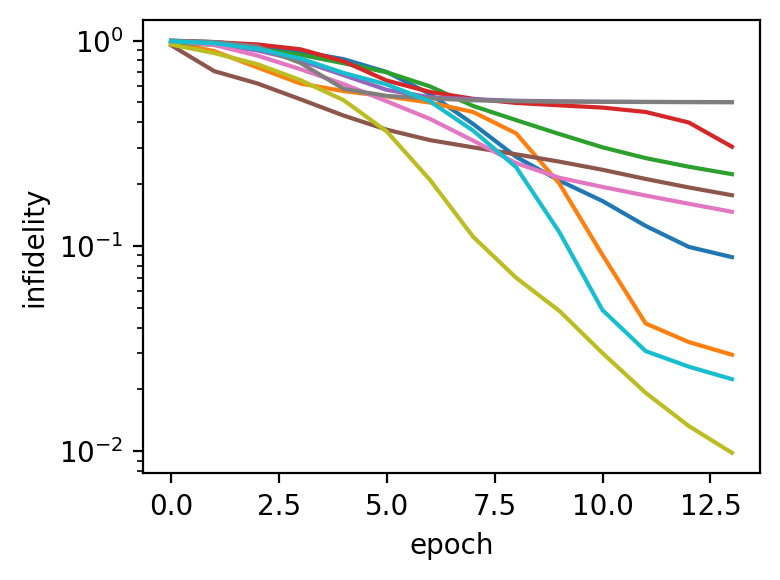

In [26]:
#We can plot the trajectories of the different parallel optimizations
analysis.plot_fidelities()

In [27]:
#We can also load the best circuit, states, and other parameters (see OptimizationAnalysis class)
best_circuit = analysis.best_circuit()
print(best_circuit)
target_state = analysis.target_state()
print(target_state)

{'fidelity': 0.99018043, 'betas': array([ 0.7026814 -0.42436263j, -3.1915953 -1.5488408j ,
        0.3234725 +0.64780205j, -0.36068666+0.74551564j,
        0.5795404 -0.9513248j , -0.6745731 +0.65914077j], dtype=complex64), 'alphas': array([ 0.7026814 -0.42436263j, -3.1915953 -1.5488408j ,
        0.3234725 +0.64780205j, -0.36068666+0.74551564j,
        0.5795404 -0.9513248j , -0.6745731 +0.65914077j], dtype=complex64), 'phis': array([ 0.7026814 -0.42436263j, -3.1915953 -1.5488408j ,
        0.3234725 +0.64780205j, -0.36068666+0.74551564j,
        0.5795404 -0.9513248j , -0.6745731 +0.65914077j], dtype=complex64), 'thetas': array([ 0.7026814 -0.42436263j, -3.1915953 -1.5488408j ,
        0.3234725 +0.64780205j, -0.36068666+0.74551564j,
        0.5795404 -0.9513248j , -0.6745731 +0.65914077j], dtype=complex64)}
Quantum object: dims = [[2, 50], [1, 1]], shape = (100, 1), type = ket
Qobj data =
[[ 1.16083083e-01+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 2.46249406e-01+3.28332

In [29]:
#Now, using the same opt object, we can sweep the number of blocks in the optimization.
sweeper = OptimizationSweeps(opt_object=opt)
sweeper.N_blocks_sweep(min_N_blocks=1, max_N_blocks=7, terminate=True) #"terminate" option specifies if it terminates sweep when term fid is met


starting N blocks sweep

N_blocks: 1
N blocks sweep filename: Cat creation.h5
N blocks sweep name: sweep N_blocks 2020-10-23 12:19:06 PM

Start time: 2020-10-23 12:19:07 PM
 Epoch: 36 / 200 Max Fid: 0.500024 Avg Fid: 0.500023 Max dFid: 0.000001 Avg dFid: 0.000000 Elapsed time: 0:00:09.231795 Remaing time: 0:00:42.055953
 max dFid: 0.000001
dFid stop: 0.000001


 Optimization stopped.  No dfid is greater than dfid_stop

optimization_type: state transfer
N_multistart: 10
N_blocks: 1
term_fid: 0.99
dfid_stop: 1e-06
no_CD_end: False
name: Cat creation
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 0.5
use_displacements: False
comment: 
alpha_cat: (2+1j)
N_cav: 50
filename: Cat creation.h5

Best circuit parameters found:
betas:         [3.99964+1.99983j]
alphas:        [0.+0.j]
phis (deg):    [0.]
thetas (deg):  [180.]
Max Fidelity:  0.500024


all data saved as: Cat creation.h5
termination reason: dfid
optimization timestamp (start time): 2020-10-23 12:19:07 P

'sweep N_blocks 2020-10-23 12:19:06 PM'

In [32]:
#the sweep data will be nicely saved to the same h5 file. We can analyze the sweep with the sweep analysis class.
sweep_analysis = OptimizationSweepsAnalysis(filename=filename)
sweep_analysis.sweep_names #names of the sweeps it found in the file

['sweep N_blocks 2020-10-23 12:18:21 PM',
 'sweep N_blocks 2020-10-23 12:19:06 PM']

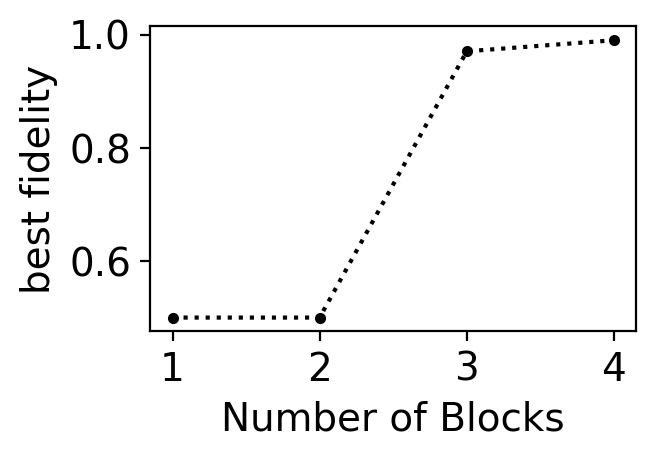

In [33]:
#we can analyze how the best fidelity found depends on the sweep parameter
sweep_analysis.plot_sweep_fidelities()

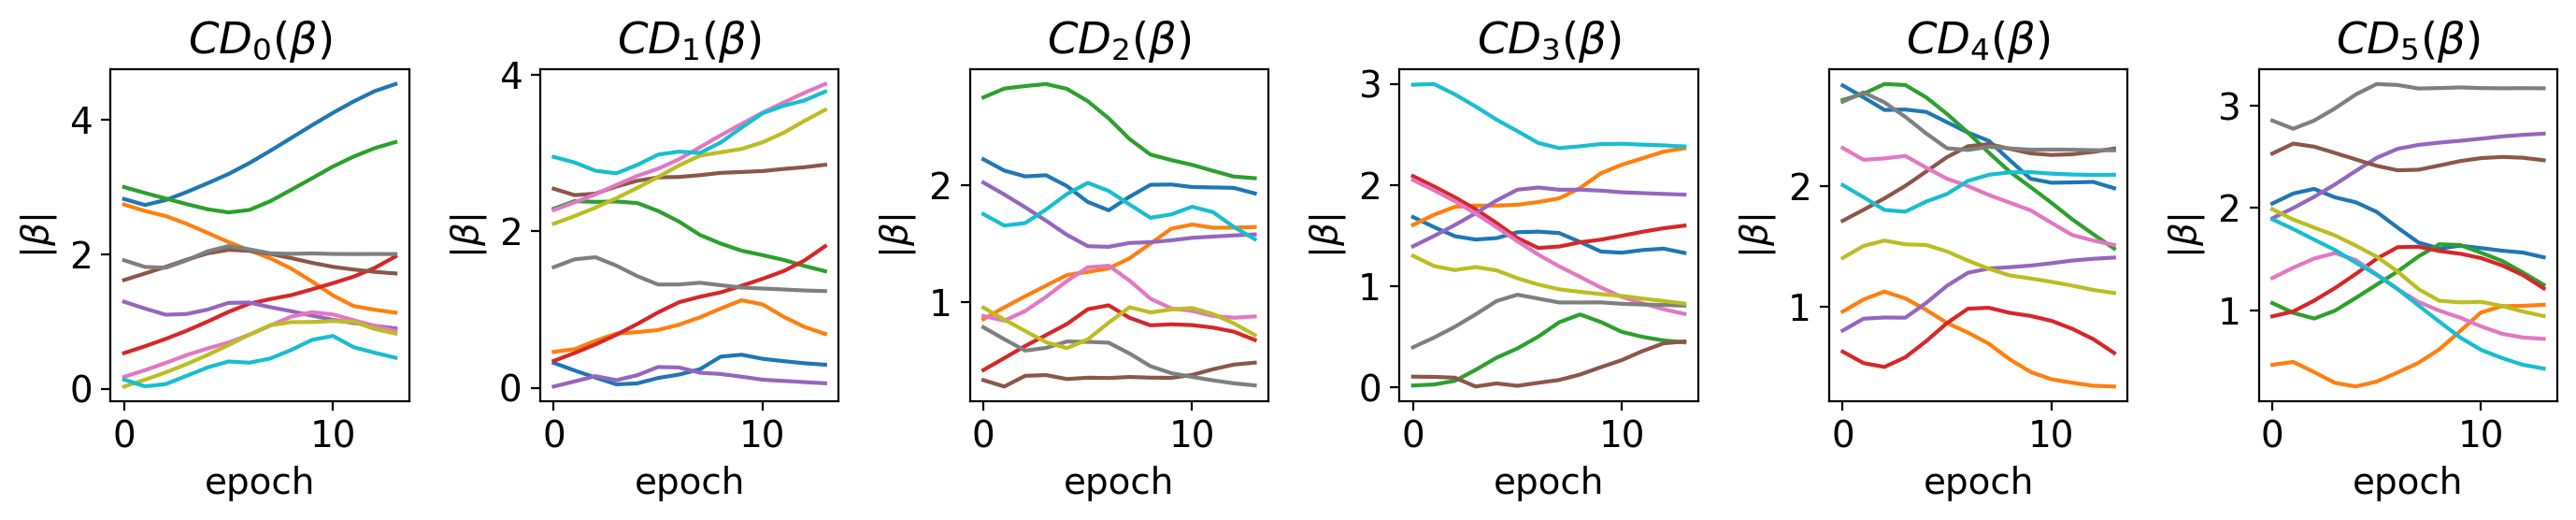

In [34]:
#there are a few other things we can plot. Better data analysis coming soon.
analysis.plot_mag_betas()

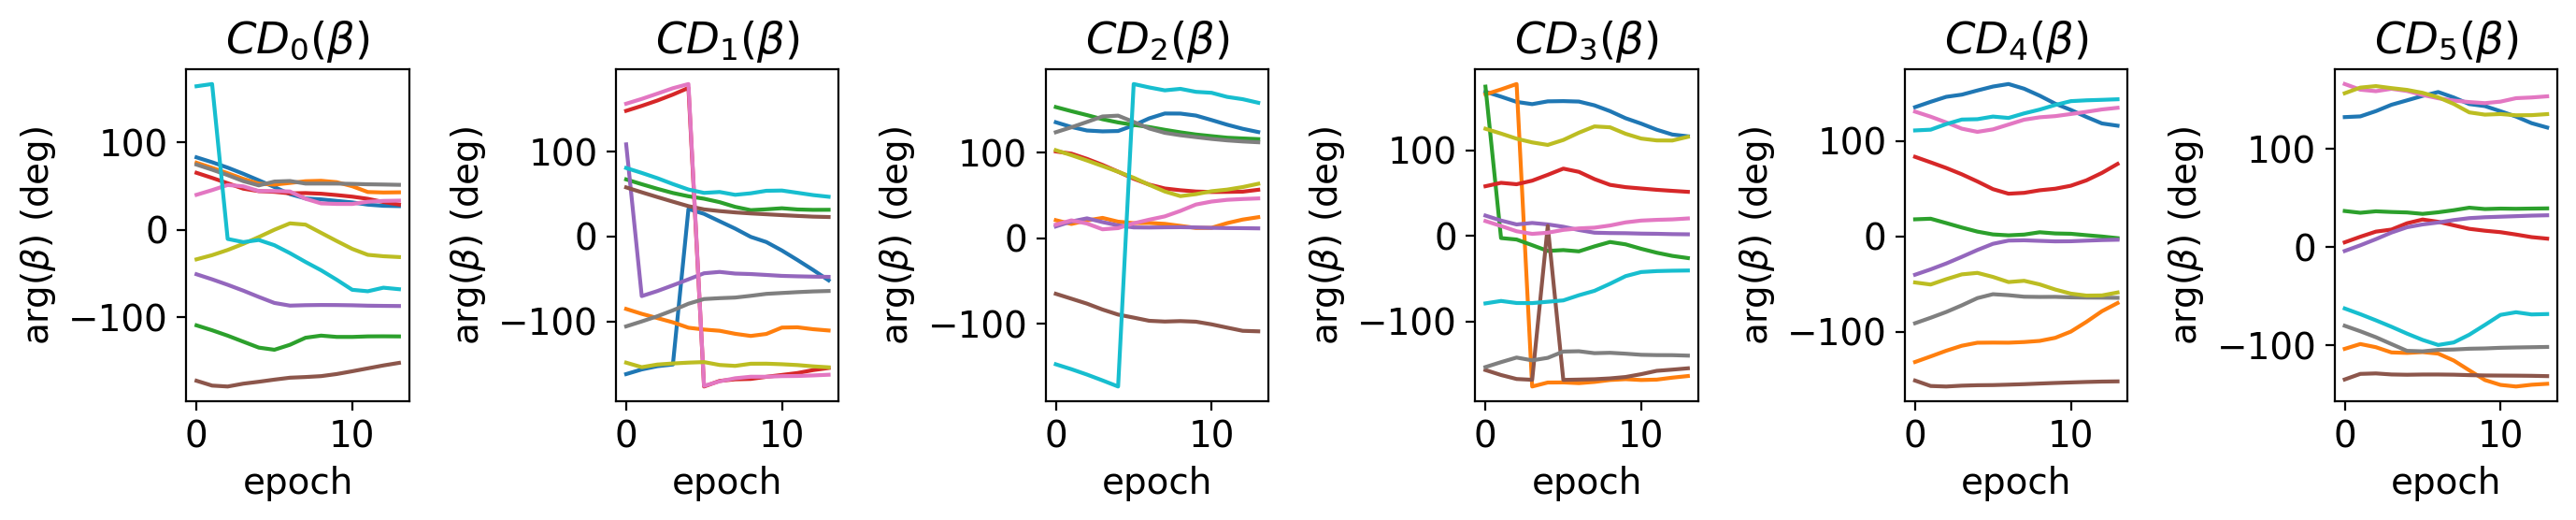

In [35]:
analysis.plot_phase_betas()

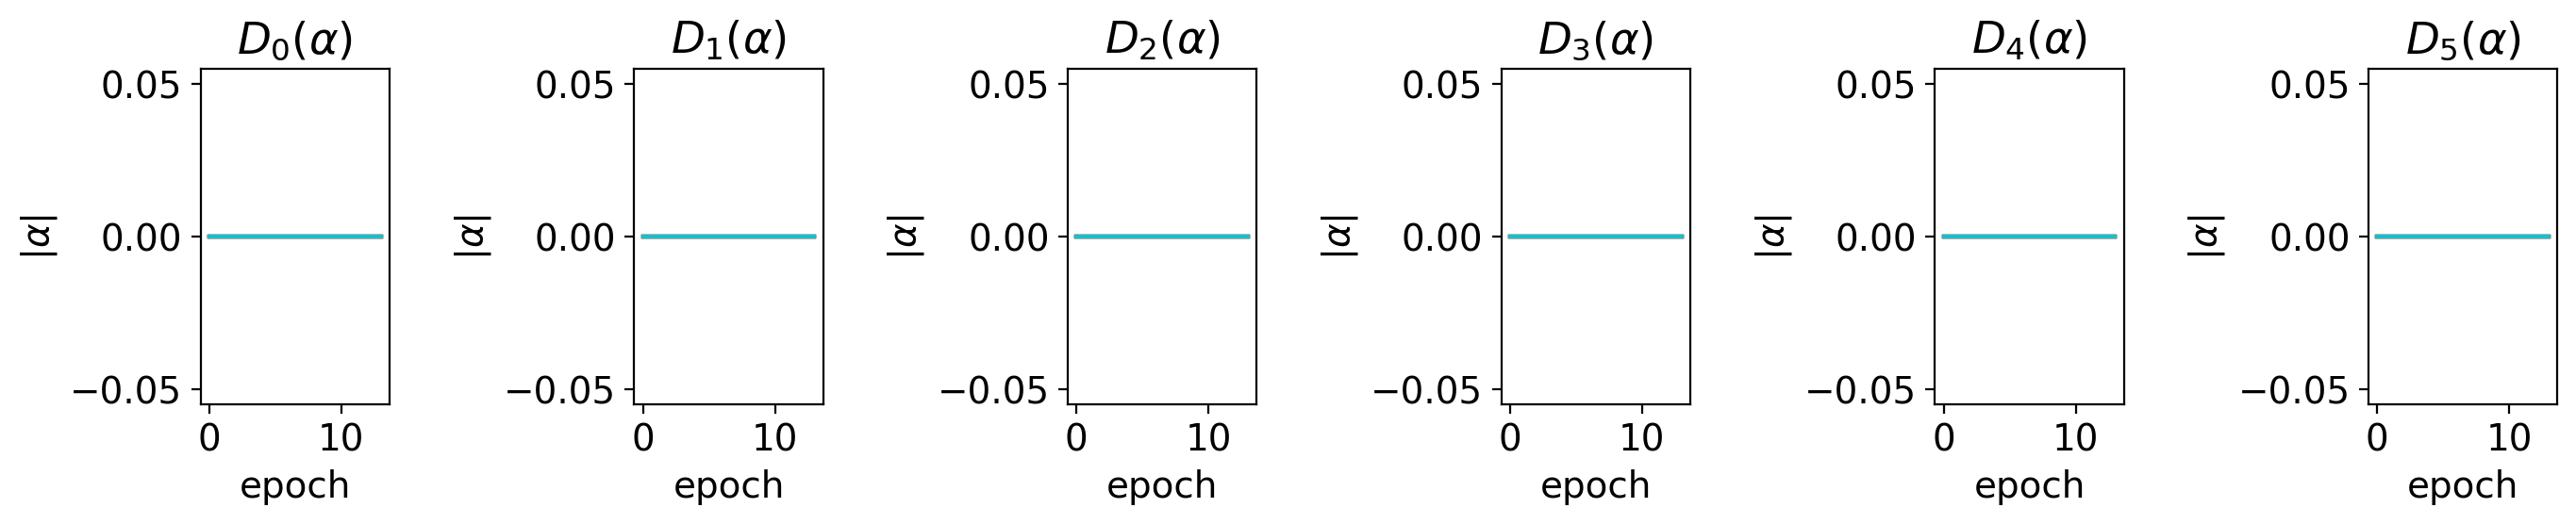

In [36]:
analysis.plot_mag_alphas()

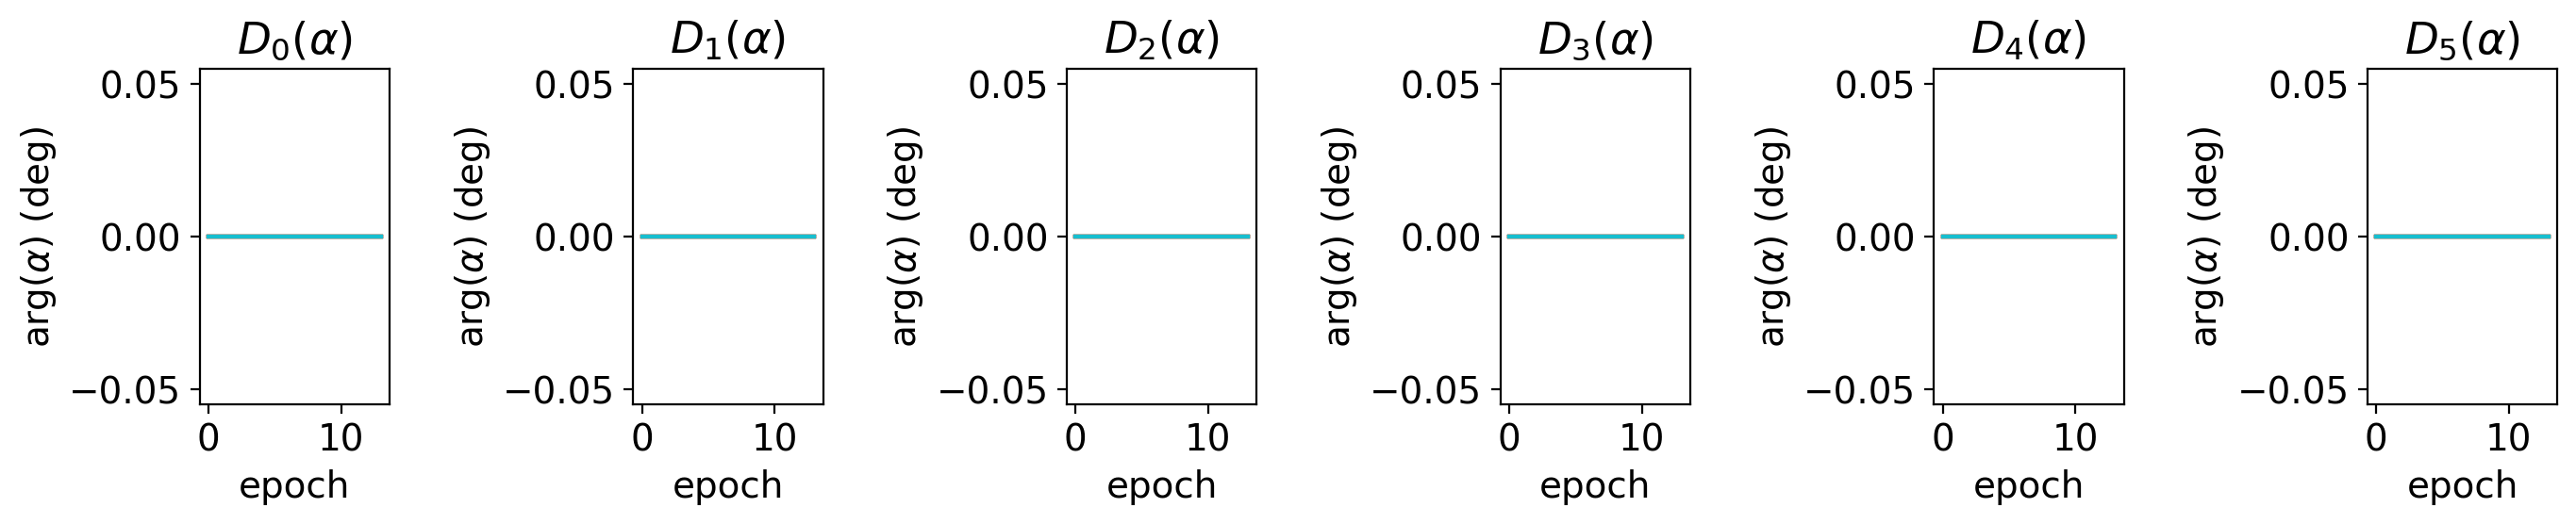

In [37]:
analysis.plot_phase_alphas()

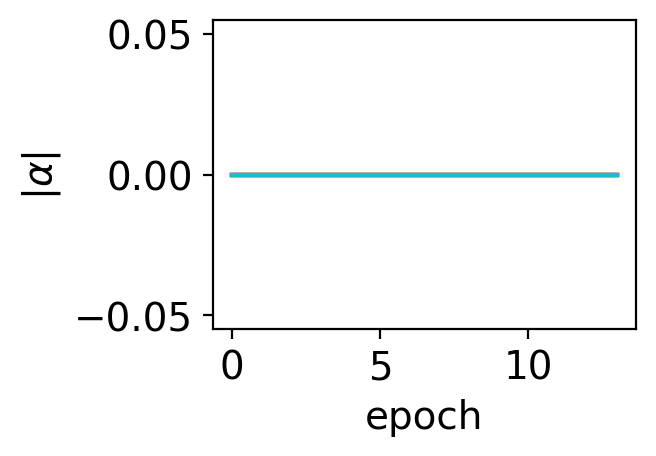

In [38]:
analysis.plot_average_magnitude_alpha()

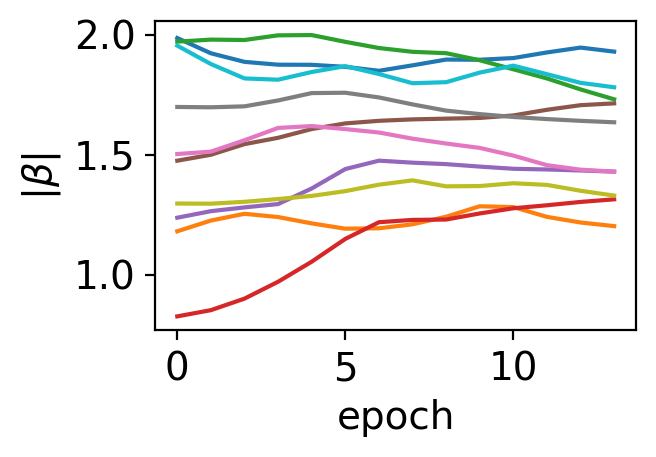

In [39]:
analysis.plot_average_magnitude_beta()